## Lab Objective

In this lab, you will explore whether you can differentiate photos taken by different people. Specifically, you’ll work with pictures taken by **Dr. Alex Dekhtyar**, **Dr. Kelly Bodwin**, or your instructor. You’ll use two machine learning approaches to determine the likely photographer for 20 unknown test images.

## Dataset Information

The dataset contains:

* Approximately **100 images taken by Alex**
* Approximately **100 images taken by Kelly**
* **20 test images** taken by **Alex, Kelly, or the instructor**

> **Note:** These images are not formatted like MNIST, so you’ll need to research how to import and process them in Python.

## Primary Goal

Your task is to identify the photographer of the 20 test images using **two distinct approaches**.

## Approach 1: Feature-Based Classification

1. Train individual (convolutional) neural networks for the following image features:

   * Presence of a **human**
   * Presence of a **castle**
   * Whether the image is taken **indoors or outdoors**
   * The **landscape type** (e.g., city, suburb, nature/rural)

2. Develop at least **10 additional features** (or feature categories) that may help distinguish between Alex's and Kelly's photos. For each, train a separate (convolutional) neural network.

3. Treat the outputs of all 14+ feature models as inputs to a final **classification model** that predicts the photographer (**Alex** or **Kelly**).

   * This final model does **not** have to be a neural network.

## Approach 2: Direct Classification

Train a **convolutional neural network** to directly classify the images as being taken by **Alex** or **Kelly**.

## Assignment Specifications

* Work in a group of **3 students**.
* You are **not allowed to use image metadata**.
* Your final deliverable must:

  * Identify your **best-performing model/approach**.
  * Include your **predictions for all 20 test images**: Alex, Kelly, or Neither.
* The training set contains only two photographers. Because your final predictions involve three classes, you **may use external data** to improve your models.

  * Any external data must be **legal, ethical, and documented** clearly.
* Your notebook should be **narrated for a non-expert audience**.

* Include all code, but explain your steps in accessible, beginner-friendly language.


## Loading in Image Data

The following code was built using inspiration and direction from the following resources:

https://www.youtube.com/watch?v=uqomO_BZ44g

https://stackoverflow.com/questions/78145837/importerror-cannot-import-name-imagedatagenerator-from-keras-preprocessing-i

https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, applications, regularizers
from sklearn.utils import class_weight


# Set Constant Image Size
IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 32
SEED = 42

import random

def set_global_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

In [2]:
# Paths
train_dir = "Alex_Kelly_Pics/train"
test_dir = "Alex_Kelly_Pics/test"

# Load training and validation datasets
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

# Load test dataset (unlabeled)
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels=None,
    shuffle=False,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=1
)

Found 715 files belonging to 3 classes.
Using 572 files for training.
Found 715 files belonging to 3 classes.
Using 143 files for validation.
Found 20 files.


### Example Images

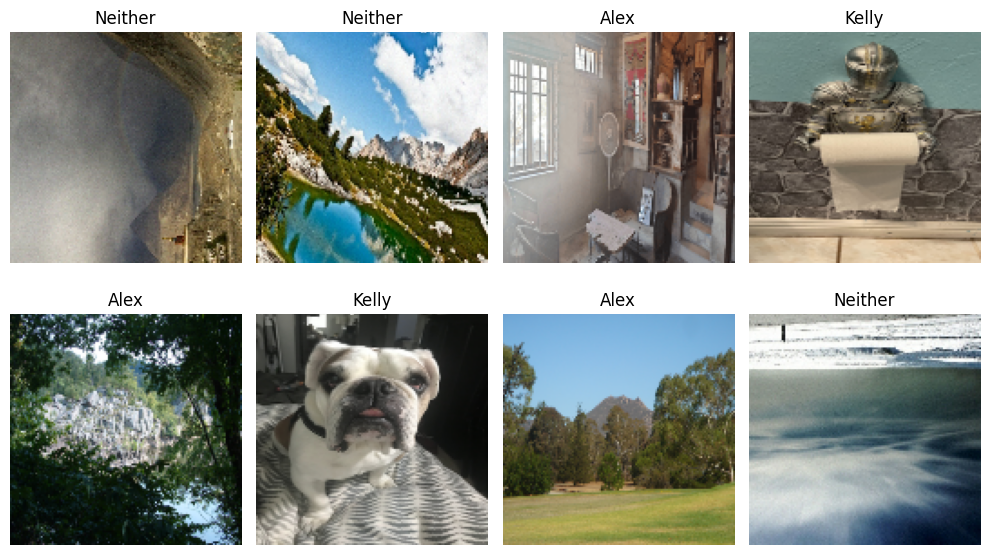

In [3]:
def visualize_batch(dataset, class_names):
    import matplotlib.pyplot as plt
    import numpy as np

    plt.figure(figsize=(10, 6))
    for images, labels in dataset.take(1):
        for i in range(8):
            ax = plt.subplot(2, 4, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[np.argmax(labels[i].numpy())])
            plt.axis("off")
    plt.tight_layout()
    plt.show()

visualize_batch(train_ds, class_names=["Alex", "Kelly", "Neither"])

### Normalize and Optimize Datasets

To prepare our images for training, we normalize the pixel values using tf.keras.layers.Rescaling(1./255). This layer scales the original RGB values from the range [0, 255] down to [0, 1], which is a standard practice in deep learning. Normalization helps the model train more efficiently by stabilizing gradients, improving convergence, and ensuring that inputs are on a consistent scale, especially important when using activation functions like ReLU or Sigmoid.

In [4]:
# Normalize images to [0, 1] range
normalization_layer = tf.keras.layers.Rescaling(1. / 255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y)).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.map(lambda x: normalization_layer(x)).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

## Approach 1: Feature Detection

In [5]:
def train_feature_cnn(feature_dir, img_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=32, epochs=20):
    train_path = os.path.join(feature_dir, "train")
    # Load unbatched dataset to extract class distribution
    raw_train_ds = tf.keras.utils.image_dataset_from_directory(
        train_path,
        image_size=img_size,
        batch_size=None,  # unbatched for label extraction
        validation_split=0.2,
        subset="training",
        seed=42,
        label_mode="binary"
    )

    # Extract labels to compute class weights
    label_list = [int(y.numpy()) for _, y in raw_train_ds]
    class_weights = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.unique(label_list),
        y=label_list
    )
    class_weights_dict = dict(enumerate(class_weights))

    # Load batched training and validation datasets
    train_ds = raw_train_ds.batch(batch_size)
    val_ds = tf.keras.utils.image_dataset_from_directory(
        train_path,
        image_size=img_size,
        batch_size=batch_size,
        validation_split=0.2,
        subset="validation",
        seed=SEED,
        label_mode="binary"
    )

    # Data augmentation for training set
    data_augmentation = tf.keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
        layers.RandomContrast(0.1),
    ])
    rescale = layers.Rescaling(1./255)

    train_ds = train_ds.map(lambda x, y: (data_augmentation(rescale(x)), y)).cache().prefetch(tf.data.AUTOTUNE)
    val_ds = val_ds.map(lambda x, y: (rescale(x), y)).cache().prefetch(tf.data.AUTOTUNE)

    # CNN model
    model = models.Sequential([
        tf.keras.Input(shape=img_size + (3,)),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train with class weights
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=[early_stop],
        class_weight=class_weights_dict
    )

    return model, history

### Human Detection

In [6]:
human_model, human_history = train_feature_cnn("Human_Pics", epochs=100)

Found 890 files belonging to 2 classes.
Using 712 files for training.


C:\Users\isabe\AppData\Local\Temp\ipykernel_52352\1286322934.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label_list = [int(y.numpy()) for _, y in raw_train_ds]


Found 890 files belonging to 2 classes.
Using 178 files for validation.
Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 0.5507 - loss: 0.7232 - val_accuracy: 0.3933 - val_loss: 0.7012
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.5886 - loss: 0.6762 - val_accuracy: 0.5674 - val_loss: 0.7622
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.6669 - loss: 0.6540 - val_accuracy: 0.5899 - val_loss: 0.7217
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.6713 - loss: 0.6413 - val_accuracy: 0.6629 - val_loss: 0.6560
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.7186 - loss: 0.6097 - val_accuracy: 0.6404 - val_loss: 0.6357
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.7149 - loss: 0.6177 - val_accuracy: 0.6685 - val_loss: 0.6499
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.7229 - loss: 0.5468 - val_accuracy: 0.6854 - val_loss: 0.6826
Epoch 8/100
23/23 ━━━━━━━━━━━━━

### Castle Detection

In [7]:
castle_model, castle_history = train_feature_cnn("Castle_Pics", epochs = 100)

Found 1424 files belonging to 2 classes.
Using 1140 files for training.


C:\Users\isabe\AppData\Local\Temp\ipykernel_52352\1286322934.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label_list = [int(y.numpy()) for _, y in raw_train_ds]


Found 1424 files belonging to 2 classes.
Using 284 files for validation.
Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - accuracy: 0.7249 - loss: 0.6597 - val_accuracy: 0.8521 - val_loss: 0.3327
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.8472 - loss: 0.3573 - val_accuracy: 0.8662 - val_loss: 0.3126
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.8624 - loss: 0.2877 - val_accuracy: 0.8556 - val_loss: 0.2841
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.8728 - loss: 0.2814 - val_accuracy: 0.8979 - val_loss: 0.2486
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.9092 - loss: 0.2290 - val_accuracy: 0.9049 - val_loss: 0.2317
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.9008 - loss: 0.2566 - val_accuracy: 0.8944 - val_loss: 0.2969
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - accuracy: 0.9212 - loss: 0.2101 - val_accuracy: 0.8944 - val_loss: 0.2475
Epoch 8/100
36/36 ━━━━━━━━━━━━━

### Food Detection

In [8]:
food_model, food_history = train_feature_cnn("Food_Pics")

Found 21183 files belonging to 2 classes.
Using 16947 files for training.


C:\Users\isabe\AppData\Local\Temp\ipykernel_52352\1286322934.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label_list = [int(y.numpy()) for _, y in raw_train_ds]


Found 21183 files belonging to 2 classes.
Using 4236 files for validation.
Epoch 1/20
530/530 ━━━━━━━━━━━━━━━━━━━━ 53s 98ms/step - accuracy: 0.7556 - loss: 0.6008 - val_accuracy: 0.8456 - val_loss: 0.3935
Epoch 2/20
530/530 ━━━━━━━━━━━━━━━━━━━━ 36s 67ms/step - accuracy: 0.8292 - loss: 0.4629 - val_accuracy: 0.8643 - val_loss: 0.2933
Epoch 3/20
530/530 ━━━━━━━━━━━━━━━━━━━━ 36s 68ms/step - accuracy: 0.8208 - loss: 0.4361 - val_accuracy: 0.8610 - val_loss: 0.3156
Epoch 4/20
530/530 ━━━━━━━━━━━━━━━━━━━━ 46s 87ms/step - accuracy: 0.8456 - loss: 0.3915 - val_accuracy: 0.9011 - val_loss: 0.2510
Epoch 5/20
530/530 ━━━━━━━━━━━━━━━━━━━━ 49s 92ms/step - accuracy: 0.8546 - loss: 0.3630 - val_accuracy: 0.8834 - val_loss: 0.3382
Epoch 6/20
530/530 ━━━━━━━━━━━━━━━━━━━━ 49s 92ms/step - accuracy: 0.8537 - loss: 0.3616 - val_accuracy: 0.8520 - val_loss: 0.3644
Epoch 7/20
530/530 ━━━━━━━━━━━━━━━━━━━━ 49s 93ms/step - accuracy: 0.8681 - loss: 0.3102 - val_accuracy: 0.8822 - val_loss: 0.2663
Epoch 8/20
530/

### Indoor / Outdoor Detecttion

In [9]:
indoor_outdoor_model, indoor_outdoor_history = train_feature_cnn("Indoor_Outdoor_Pics")

Found 770 files belonging to 2 classes.
Using 616 files for training.


C:\Users\isabe\AppData\Local\Temp\ipykernel_52352\1286322934.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label_list = [int(y.numpy()) for _, y in raw_train_ds]


Found 770 files belonging to 2 classes.
Using 154 files for validation.
Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 153ms/step - accuracy: 0.4892 - loss: 0.9045 - val_accuracy: 0.7338 - val_loss: 0.5661
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 0.6927 - loss: 0.6010 - val_accuracy: 0.7597 - val_loss: 0.4916
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 0.7020 - loss: 0.5476 - val_accuracy: 0.7792 - val_loss: 0.4464
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 0.7556 - loss: 0.5177 - val_accuracy: 0.7727 - val_loss: 0.5169
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.7608 - loss: 0.5063 - val_accuracy: 0.7727 - val_loss: 0.5266
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.7886 - loss: 0.4473 - val_accuracy: 0.8052 - val_loss: 0.4650
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.8341 - loss: 0.4108 - val_accuracy: 0.7662 - val_loss: 0.6253
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 

### Pet Detection

In [10]:
pet_model, pet_history = train_feature_cnn("Pet_Pics")

Found 18728 files belonging to 2 classes.
Using 14983 files for training.


C:\Users\isabe\AppData\Local\Temp\ipykernel_52352\1286322934.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label_list = [int(y.numpy()) for _, y in raw_train_ds]


Found 18728 files belonging to 2 classes.
Using 3745 files for validation.
Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 70s 144ms/step - accuracy: 0.5511 - loss: 0.6947 - val_accuracy: 0.6593 - val_loss: 0.6008
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 43s 92ms/step - accuracy: 0.6832 - loss: 0.5908 - val_accuracy: 0.7178 - val_loss: 0.5677
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 43s 92ms/step - accuracy: 0.7419 - loss: 0.5233 - val_accuracy: 0.7720 - val_loss: 0.4944
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 44s 93ms/step - accuracy: 0.7787 - loss: 0.4686 - val_accuracy: 0.7824 - val_loss: 0.4972
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 44s 94ms/step - accuracy: 0.8043 - loss: 0.4275 - val_accuracy: 0.7880 - val_loss: 0.5179
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 45s 96ms/step - accuracy: 0.8279 - loss: 0.3830 - val_accuracy: 0.7893 - val_loss: 0.5482
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 45s 96ms/step - accuracy: 0.8547 - loss: 0.3360 - val_accuracy: 0.8115 - val_loss: 0.5403
Epoch 8/20
469

### Vehicle Detection

In [11]:
vehicle_model, vehicle_history = train_feature_cnn("Vehicle_Pics")

Found 17730 files belonging to 2 classes.
Using 14184 files for training.


C:\Users\isabe\AppData\Local\Temp\ipykernel_52352\1286322934.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label_list = [int(y.numpy()) for _, y in raw_train_ds]


Found 17730 files belonging to 2 classes.
Using 3546 files for validation.
Epoch 1/20
444/444 ━━━━━━━━━━━━━━━━━━━━ 66s 143ms/step - accuracy: 0.8439 - loss: 0.3225 - val_accuracy: 0.9670 - val_loss: 0.0921
Epoch 2/20
444/444 ━━━━━━━━━━━━━━━━━━━━ 41s 92ms/step - accuracy: 0.9694 - loss: 0.0884 - val_accuracy: 0.9828 - val_loss: 0.0595
Epoch 3/20
444/444 ━━━━━━━━━━━━━━━━━━━━ 41s 92ms/step - accuracy: 0.9697 - loss: 0.0830 - val_accuracy: 0.9873 - val_loss: 0.0424
Epoch 4/20
444/444 ━━━━━━━━━━━━━━━━━━━━ 41s 93ms/step - accuracy: 0.9768 - loss: 0.0704 - val_accuracy: 0.9915 - val_loss: 0.0294
Epoch 5/20
444/444 ━━━━━━━━━━━━━━━━━━━━ 42s 94ms/step - accuracy: 0.9883 - loss: 0.0345 - val_accuracy: 0.9901 - val_loss: 0.0295
Epoch 6/20
444/444 ━━━━━━━━━━━━━━━━━━━━ 42s 96ms/step - accuracy: 0.9876 - loss: 0.0383 - val_accuracy: 0.9913 - val_loss: 0.0252
Epoch 7/20
444/444 ━━━━━━━━━━━━━━━━━━━━ 43s 96ms/step - accuracy: 0.9865 - loss: 0.0415 - val_accuracy: 0.9873 - val_loss: 0.0381
Epoch 8/20
444

### Flower Detection

In [12]:
flower_model, flower_history = train_feature_cnn("Flower_Pics")

Found 1367 files belonging to 2 classes.
Using 1094 files for training.


C:\Users\isabe\AppData\Local\Temp\ipykernel_52352\1286322934.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label_list = [int(y.numpy()) for _, y in raw_train_ds]


Found 1367 files belonging to 2 classes.
Using 273 files for validation.
Epoch 1/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 181ms/step - accuracy: 0.6463 - loss: 0.6103 - val_accuracy: 0.8095 - val_loss: 0.4473
Epoch 2/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - accuracy: 0.8942 - loss: 0.2854 - val_accuracy: 0.8974 - val_loss: 0.2309
Epoch 3/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 0.9298 - loss: 0.1955 - val_accuracy: 0.9194 - val_loss: 0.1660
Epoch 4/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - accuracy: 0.9519 - loss: 0.1291 - val_accuracy: 0.9084 - val_loss: 0.2001
Epoch 5/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - accuracy: 0.9483 - loss: 0.1053 - val_accuracy: 0.9048 - val_loss: 0.2046
Epoch 6/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - accuracy: 0.9629 - loss: 0.0967 - val_accuracy: 0.9048 - val_loss: 0.2889
Epoch 7/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - accuracy: 0.9671 - loss: 0.0876 - val_accuracy: 0.9194 - val_loss: 0.2088
Epoch 8/20
35/35 ━━━━━━━━━━━━━━━━━━━━

### Forest Detection

In [13]:
forest_model, forest_history = train_feature_cnn("Forest_Pics")

Found 3997 files belonging to 2 classes.
Using 3198 files for training.


C:\Users\isabe\AppData\Local\Temp\ipykernel_52352\1286322934.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label_list = [int(y.numpy()) for _, y in raw_train_ds]


Found 3997 files belonging to 2 classes.
Using 799 files for validation.
Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 177ms/step - accuracy: 0.7458 - loss: 0.4798 - val_accuracy: 0.9474 - val_loss: 0.1693
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 93ms/step - accuracy: 0.9390 - loss: 0.1624 - val_accuracy: 0.9587 - val_loss: 0.1322
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 94ms/step - accuracy: 0.9560 - loss: 0.1169 - val_accuracy: 0.9599 - val_loss: 0.1181
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 93ms/step - accuracy: 0.9712 - loss: 0.0843 - val_accuracy: 0.9549 - val_loss: 0.1390
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 94ms/step - accuracy: 0.9678 - loss: 0.0895 - val_accuracy: 0.9587 - val_loss: 0.1241
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 97ms/step - accuracy: 0.9711 - loss: 0.0741 - val_accuracy: 0.9750 - val_loss: 0.0690
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 97ms/step - accuracy: 0.9750 - loss: 0.0695 - val_accuracy: 0.9700 - val_loss: 0.0868
Epoch 8/20
100/100 ━

### Glacier Detection

In [14]:
glacier_model, glacier_history = train_feature_cnn("Glacier_Pics")

Found 4198 files belonging to 2 classes.
Using 3359 files for training.


C:\Users\isabe\AppData\Local\Temp\ipykernel_52352\1286322934.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label_list = [int(y.numpy()) for _, y in raw_train_ds]


Found 4198 files belonging to 2 classes.
Using 839 files for validation.
Epoch 1/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 18s 157ms/step - accuracy: 0.7624 - loss: 0.4786 - val_accuracy: 0.9035 - val_loss: 0.2580
Epoch 2/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 10s 93ms/step - accuracy: 0.9007 - loss: 0.2620 - val_accuracy: 0.9046 - val_loss: 0.2798
Epoch 3/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - accuracy: 0.9169 - loss: 0.2384 - val_accuracy: 0.8892 - val_loss: 0.3363
Epoch 4/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 10s 93ms/step - accuracy: 0.9209 - loss: 0.2201 - val_accuracy: 0.8665 - val_loss: 0.3420
Epoch 5/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step - accuracy: 0.9286 - loss: 0.2002 - val_accuracy: 0.9094 - val_loss: 0.2406
Epoch 6/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - accuracy: 0.9366 - loss: 0.1799 - val_accuracy: 0.9285 - val_loss: 0.2005
Epoch 7/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - accuracy: 0.9401 - loss: 0.1674 - val_accuracy: 0.9249 - val_loss: 0.2171
Epoch 8/20
105/1

### Mountain Detection

In [15]:
mountain_model, mountain_history = train_feature_cnn("Mountain_Pics")

Found 4198 files belonging to 2 classes.
Using 3359 files for training.


C:\Users\isabe\AppData\Local\Temp\ipykernel_52352\1286322934.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label_list = [int(y.numpy()) for _, y in raw_train_ds]


Found 4198 files belonging to 2 classes.
Using 839 files for validation.
Epoch 1/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 21s 176ms/step - accuracy: 0.7483 - loss: 0.5314 - val_accuracy: 0.8713 - val_loss: 0.3006
Epoch 2/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - accuracy: 0.8719 - loss: 0.3298 - val_accuracy: 0.8832 - val_loss: 0.3015
Epoch 3/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 10s 93ms/step - accuracy: 0.8893 - loss: 0.3052 - val_accuracy: 0.8760 - val_loss: 0.3034
Epoch 4/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 10s 93ms/step - accuracy: 0.8877 - loss: 0.2898 - val_accuracy: 0.8760 - val_loss: 0.3219
Epoch 5/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step - accuracy: 0.8952 - loss: 0.2786 - val_accuracy: 0.8939 - val_loss: 0.2709
Epoch 6/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 9s 86ms/step - accuracy: 0.9013 - loss: 0.2572 - val_accuracy: 0.9023 - val_loss: 0.2710
Epoch 7/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 8s 73ms/step - accuracy: 0.9123 - loss: 0.2270 - val_accuracy: 0.8939 - val_loss: 0.2788
Epoch 8/20
105/105

### Ocean/Sea Detection

In [16]:
sea_model, sea_history = train_feature_cnn("Sea_Pics")

Found 3823 files belonging to 2 classes.
Using 3059 files for training.


C:\Users\isabe\AppData\Local\Temp\ipykernel_52352\1286322934.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label_list = [int(y.numpy()) for _, y in raw_train_ds]


Found 3823 files belonging to 2 classes.
Using 764 files for validation.
Epoch 1/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 11s 102ms/step - accuracy: 0.6822 - loss: 0.5420 - val_accuracy: 0.8966 - val_loss: 0.2965
Epoch 2/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - accuracy: 0.8668 - loss: 0.3275 - val_accuracy: 0.9045 - val_loss: 0.2644
Epoch 3/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.8817 - loss: 0.3052 - val_accuracy: 0.9005 - val_loss: 0.2538
Epoch 4/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.8939 - loss: 0.2712 - val_accuracy: 0.9149 - val_loss: 0.2283
Epoch 5/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.9019 - loss: 0.2705 - val_accuracy: 0.9202 - val_loss: 0.2491
Epoch 6/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.9193 - loss: 0.2356 - val_accuracy: 0.9084 - val_loss: 0.2561
Epoch 7/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.9251 - loss: 0.2186 - val_accuracy: 0.9202 - val_loss: 0.2609
Epoch 8/20
96/96 ━━━━━━━━━━━━━━━━━━━

### Street Detection

In [17]:
street_model, street_history = train_feature_cnn("Street_Pics")

Found 4163 files belonging to 2 classes.
Using 3331 files for training.


C:\Users\isabe\AppData\Local\Temp\ipykernel_52352\1286322934.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label_list = [int(y.numpy()) for _, y in raw_train_ds]


Found 4163 files belonging to 2 classes.
Using 832 files for validation.
Epoch 1/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 12s 102ms/step - accuracy: 0.6107 - loss: 0.6388 - val_accuracy: 0.8738 - val_loss: 0.3120
Epoch 2/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - accuracy: 0.8479 - loss: 0.3701 - val_accuracy: 0.9111 - val_loss: 0.2548
Epoch 3/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.8901 - loss: 0.3075 - val_accuracy: 0.8918 - val_loss: 0.2614
Epoch 4/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.8955 - loss: 0.2805 - val_accuracy: 0.9002 - val_loss: 0.2345
Epoch 5/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.8972 - loss: 0.2697 - val_accuracy: 0.9147 - val_loss: 0.2025
Epoch 6/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.9040 - loss: 0.2445 - val_accuracy: 0.9231 - val_loss: 0.1862
Epoch 7/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 8s 72ms/step - accuracy: 0.9130 - loss: 0.2234 - val_accuracy: 0.9279 - val_loss: 0.1765
Epoch 8/20
105/105 ━━━

### Day/Night Classification

In [18]:
daynight_model, daynight_history = train_feature_cnn("DayNight_Pics")

Found 240 files belonging to 2 classes.
Using 192 files for training.
Found 240 files belonging to 2 classes.
Using 48 files for validation.


C:\Users\isabe\AppData\Local\Temp\ipykernel_52352\1286322934.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label_list = [int(y.numpy()) for _, y in raw_train_ds]


Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 0.5688 - loss: 0.6159 - val_accuracy: 0.8125 - val_loss: 0.5082
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9061 - loss: 0.2296 - val_accuracy: 0.8958 - val_loss: 0.2737
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9741 - loss: 0.0459 - val_accuracy: 0.9792 - val_loss: 0.0202
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9863 - loss: 0.0229 - val_accuracy: 1.0000 - val_loss: 0.0052
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 0.0078 - val_accuracy: 0.9792 - val_loss: 0.0391
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9889 - loss: 0.0169 - val_accuracy: 1.0000 - val_loss: 0.0055
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9928 - loss: 0.0097 - val_accuracy: 0.9792 - val_loss: 0.0411
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 0.0036 - val_accuracy: 1.0000 - val_loss: 0.0060

## Approach 2: CNN 

To prevent overfitting and ensure generalization, we used early stopping with restore_best_weights=True. This allowed the model to automatically revert to the epoch that achieved the lowest validation loss. As a result, our final model reflects the best performance observed during training.

In [19]:
# Set seeds for reproducibility
seed_value = 42
tf.random.set_seed(seed_value)
np.random.seed(seed_value)
random.seed(seed_value)
os.environ['PYTHONHASHSEED'] = str(seed_value)

def train_alex_kelly_classifier_transfer(data_dir="Alex_Kelly_Pics/train", img_size=(128, 128), batch_size=32, epochs=30):
    # Step 1: Load raw dataset for class weight calculation (use int labels)
    raw_label_ds = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        validation_split=0.2,
        subset="training",
        seed=SEED,
        image_size=img_size,
        batch_size=batch_size,
        label_mode="int"
    )

    y_train_int = []
    for _, labels in raw_label_ds:
        y_train_int.extend(labels.numpy())
    y_train_int = np.array(y_train_int)

    class_weights = dict(enumerate(class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train_int),
        y=y_train_int
    )))

    # Step 2: Load datasets again for model training (same int labels)
    train_ds = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        validation_split=0.2,
        subset="training",
        seed=42,
        image_size=img_size,
        batch_size=batch_size,
        label_mode="int"
    )

    val_ds = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        validation_split=0.2,
        subset="validation",
        seed=42,
        image_size=img_size,
        batch_size=batch_size,
        label_mode="int"
    )

    # Step 3: Normalize and augment
    rescale = layers.Rescaling(1./255)
    augmentation = tf.keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1)
    ])

    train_ds = train_ds.map(lambda x, y: (augmentation(rescale(x)), y)).cache().prefetch(tf.data.AUTOTUNE)
    val_ds = val_ds.map(lambda x, y: (rescale(x), y)).cache().prefetch(tf.data.AUTOTUNE)

    # Step 4: Define transfer learning model
    base_model = applications.MobileNetV2(input_shape=img_size + (3,),
                                          include_top=False,
                                          weights="imagenet")
    base_model.trainable = False  # Freeze base

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.5),
        layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        layers.Dense(3, activation='softmax')  # 3 classes: Alex, Kelly, Neither
    ])

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # Step 5: Train with early stopping and class weights
    early_stop = callbacks.EarlyStopping(patience=5, restore_best_weights=True)
    history = model.fit(train_ds, validation_data=val_ds,
                        epochs=epochs,
                        class_weight=class_weights,
                        callbacks=[early_stop])

    return model, history

In [20]:
model, history = train_alex_kelly_classifier_transfer()

Found 715 files belonging to 3 classes.
Using 572 files for training.
Found 715 files belonging to 3 classes.
Using 572 files for training.
Found 715 files belonging to 3 classes.
Using 143 files for validation.
Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 154ms/step - accuracy: 0.3909 - loss: 2.8884 - val_accuracy: 0.5874 - val_loss: 2.0407
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - accuracy: 0.6085 - loss: 1.9375 - val_accuracy: 0.7483 - val_loss: 1.7938
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.7181 - loss: 1.7411 - val_accuracy: 0.7552 - val_loss: 1.6054
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.7780 - loss: 1.5105 - val_accuracy: 0.7622 - val_loss: 1.4773
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.8057 - loss: 1.3489 - val_accuracy: 0.7483 - val_loss: 1.4210
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.7876 - loss: 1.2734 - val_accuracy: 0.7552 - val_loss: 1.2917
Epoch 7/30
18/18 ━━━━━━━━

In [21]:
from tensorflow.keras.preprocessing import image
def predict_and_visualize_thresholded(model, test_dir, class_names, img_size=(128, 128), threshold=0.6, max_images=20):
    image_files = sorted([
        f for f in os.listdir(test_dir)
        if f.lower().endswith(('.jpg', '.jpeg', '.png'))
    ])[:max_images]

    plt.figure(figsize=(15, 8))

    for i, fname in enumerate(image_files):
        img_path = os.path.join(test_dir, fname)
        img = image.load_img(img_path, target_size=img_size)
        img_array = image.img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        prediction = model.predict(img_array, verbose=0)[0]
        predicted_idx = np.argmax(prediction)
        confidence = prediction[predicted_idx]

        if confidence < threshold:
            predicted_label = "Neither"
        else:
            predicted_label = class_names[predicted_idx]

        ax = plt.subplot(4, 5, i + 1)
        plt.imshow(img)
        plt.title(f"{predicted_label}\n({confidence:.2f})", fontsize=9)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

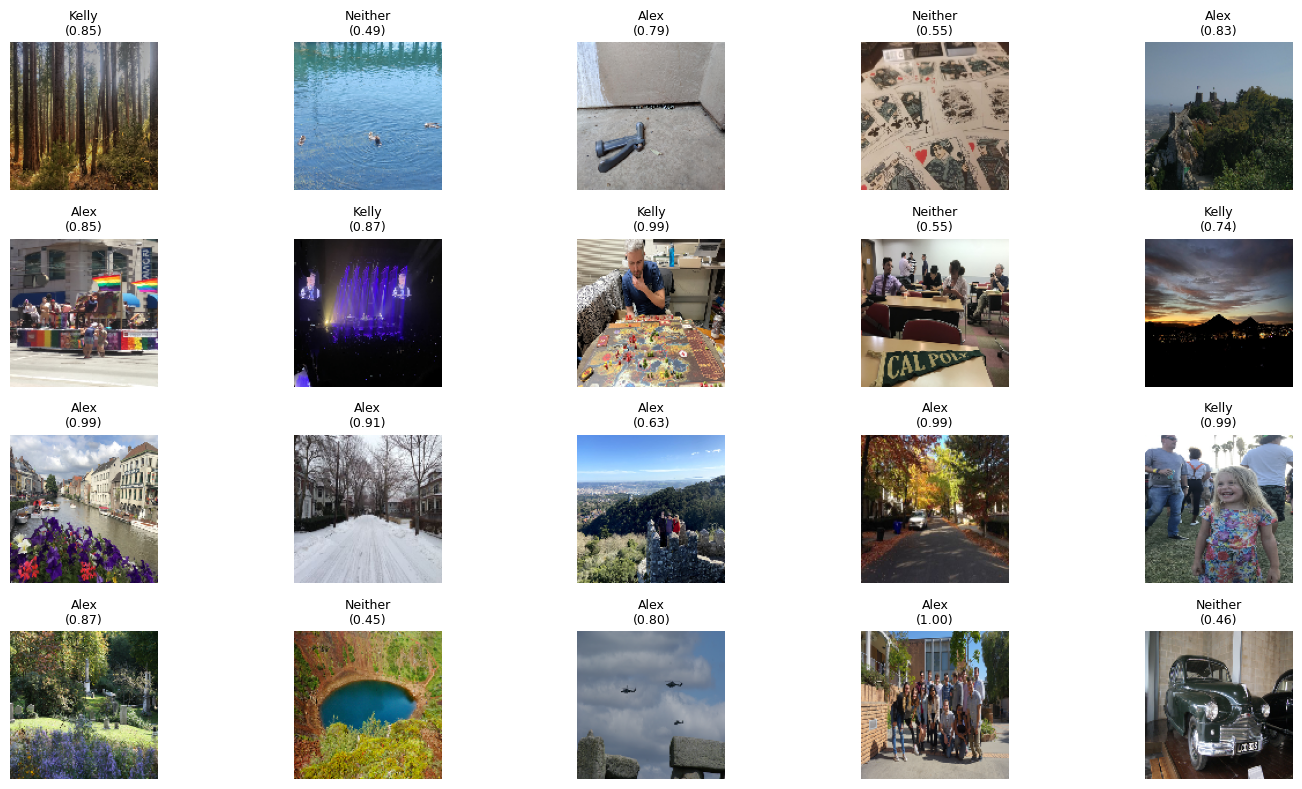

In [22]:
test_dir = "Alex_Kelly_Pics/test/TestSet"
class_names = ["Alex", "Kelly", "Neither"]
predict_and_visualize_thresholded(model, test_dir, class_names)